In [1]:
# 1. Install Dependencies and Setup
%pip install tensorflow tensorflow-gpu opencv-python matplotlib
%pip list

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\ADEBOSS\AppData\Local\Temp\pip-install-vuvnopym\tensorflow-gpu_37a9ff39be7443e79faafa68c25c7ba8\setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
ERROR: Could not bu

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
Note: you may need to restart the kernel to use updated packages.
Package                      Version
---------------------------- -----------
absl-py                      1.4.0
asttokens                    2.2.1
astunparse                   1.6.3
autopep8                     2.0.0
backcall                     0.2.0
beautifulsoup4               4.11.1
blinker                      1.6.2
bs4                          0.0.1
cachetools                   5.3.0
certifi                      2022.12.7
cffi                         1.15.1
charset-normalizer           3.0.1
click                        8.1.3
colorama                     0.4.6
comm                         0.1.3
confusion-matrix             0.1
contourpy                    1.0.7
cycler                     

In [2]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')


[]

In [6]:
# 2. Remove dodgy images
import cv2
import imghdr

data_dir = 'ISIC/train'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']
allowed_classes =['basal cell carcinoma', 'melanoma', 'squamous cell carcinoma']

for image_class in os.listdir(data_dir):
    if image_class not in allowed_classes:
        continue 
    
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

Found 1043 files belonging to 3 classes.


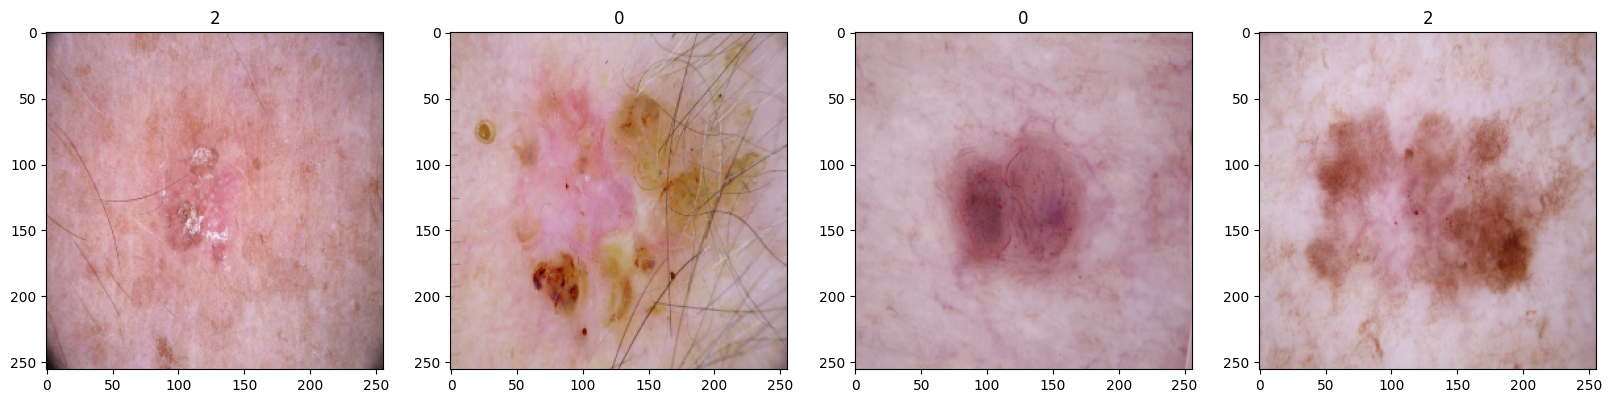

In [7]:
# 3. Load Data
import numpy as np
from matplotlib import pyplot as plt
data = tf.keras.utils.image_dataset_from_directory('ISIC/train', labels='inferred', label_mode='int', class_names=allowed_classes)
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
plt.show()

In [8]:
# 4. Scale Data
data = data.map(lambda x, y: (x / 255, y))
data.as_numpy_iterator().next()


(array([[[[0.65882355, 0.6019608 , 0.5392157 ],
          [0.6627451 , 0.62941176, 0.5745098 ],
          [0.66862744, 0.6372549 , 0.5862745 ],
          ...,
          [0.6627451 , 0.5411765 , 0.47058824],
          [0.67058825, 0.5627451 , 0.48039216],
          [0.67058825, 0.57254905, 0.4862745 ]],
 
         [[0.6843137 , 0.6333333 , 0.56666666],
          [0.67058825, 0.6392157 , 0.5745098 ],
          [0.68039215, 0.6490196 , 0.5882353 ],
          ...,
          [0.6666667 , 0.5568628 , 0.4745098 ],
          [0.6745098 , 0.57254905, 0.49215686],
          [0.66862744, 0.5764706 , 0.49607843]],
 
         [[0.6784314 , 0.63529414, 0.5647059 ],
          [0.67058825, 0.6372549 , 0.56666666],
          [0.68039215, 0.64509803, 0.57843137],
          ...,
          [0.6784314 , 0.57254905, 0.49019608],
          [0.67058825, 0.57254905, 0.49411765],
          [0.6666667 , 0.5764706 , 0.5058824 ]],
 
         ...,
 
         [[0.67058825, 0.6       , 0.53137255],
          [0.66666

In [9]:
# 5. Split Data
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)
train_size, val_size, test_size

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)


In [10]:
# 6. Build Deep Learning Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


In [11]:
model = Sequential()
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 4 output classes
model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [12]:
# 7. Train
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=30, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/30
23/23 [==============================] - 123s 5s/step - loss: 1.1286 - accuracy: 0.4660 - val_loss: 0.9082 - val_accuracy: 0.6719
Epoch 2/30
23/23 [==============================] - 103s 4s/step - loss: 0.7885 - accuracy: 0.6726 - val_loss: 0.7609 - val_accuracy: 0.6302
Epoch 3/30
23/23 [==============================] - 102s 4s/step - loss: 0.7637 - accuracy: 0.6644 - val_loss: 0.6056 - val_accuracy: 0.7708
Epoch 4/30
23/23 [==============================] - 101s 4s/step - loss: 0.6392 - accuracy: 0.7215 - val_loss: 0.6481 - val_accuracy: 0.6979
Epoch 5/30
23/23 [==============================] - 84s 4s/step - loss: 0.5961 - accuracy: 0.7514 - val_loss: 0.5597 - val_accuracy: 0.7448
Epoch 6/30
23/23 [==============================] - 85s 4s/step - loss: 0.6135 - accuracy: 0.7337 - val_loss: 0.6804 - val_accuracy: 0.7240
Epoch 7/30
23/23 [==============================] - 102s 4s/step - loss: 0.5934 - accuracy: 0.7337 - val_loss: 0.6126 - val_accuracy: 0.7448
Epoch 8/30
23/2

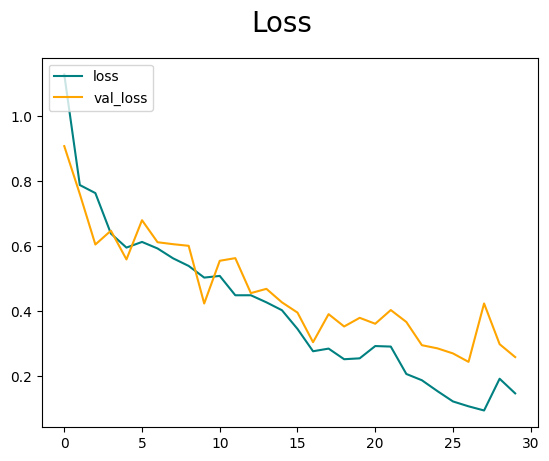

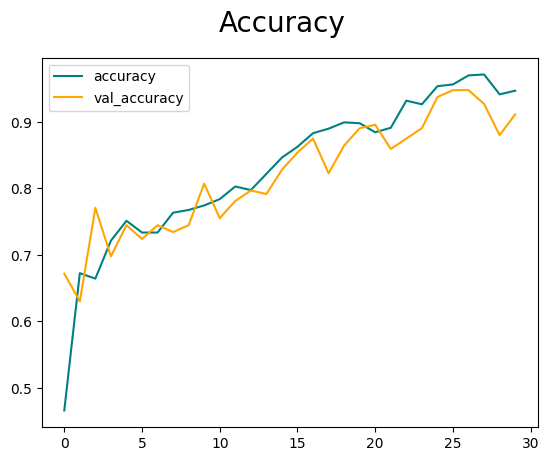

In [13]:
# 8. Plot Performance
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [14]:
# 9. Evaluate
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    yhat_classes = np.argmax(yhat, axis=-1)  # Get the predicted class indices
    
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)
print(pre.result(), re.result(), acc.result())


1/1 [==============================] - 1s 1s/step
tf.Tensor(0.983871, shape=(), dtype=float32) tf.Tensor(0.92424244, shape=(), dtype=float32) tf.Tensor(0.7291667, shape=(), dtype=float32)


In [15]:
# 10. Test
import cv2

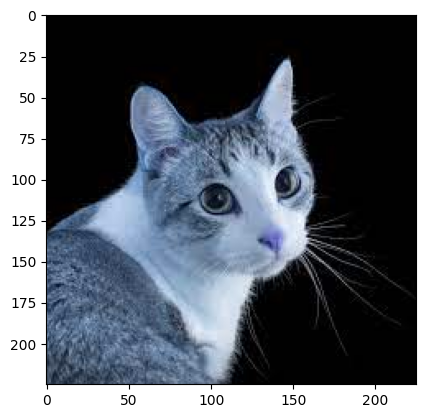

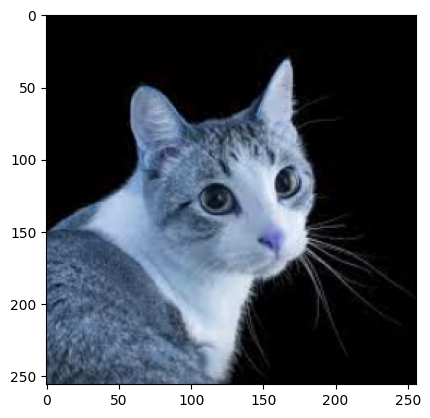

1/1 [==============================] - 0s 53ms/step
Image does not belong to skin cancer.


In [17]:
img = cv2.imread('ISIC/download.jpg')
plt.imshow(img)
plt.show()

resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize / 255, 0))
predicted_class = np.argmax(yhat)  # Get the index of the highest probability class

classes = ['Basal cell Carcinoma', 'Melanoma', 'Squamous cell carcinoma']

if classes[predicted_class] in allowed_classes:
    print(f'score : {[yhat]}')
    print(f'Predicted class is a {classes[predicted_class]}')

else:
    print('Image does not belong to skin cancer.')

In [18]:
# 11. Save the Model
from tensorflow.keras.models import load_model

model.save(os.path.join('models', 'imageclassifier.h5'))
new_model = load_model('models/imageclassifier.h5')
new_model.predict(np.expand_dims(resize / 255, 0))


1/1 [==============================] - 0s 281ms/step


array([[0.000000e+00, 1.000000e+00, 8.504131e-31]], dtype=float32)